In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# import imutils
import math

In [7]:
plt.rcParams['figure.figsize'] = [10,8]

In [8]:
path_1 = "img/pikachu_board_1.png"

## Load and work on level 1 Pikachu Image.

Load image and turn it to grayscale.

In [9]:
img_1 = cv2.imread(path_1)

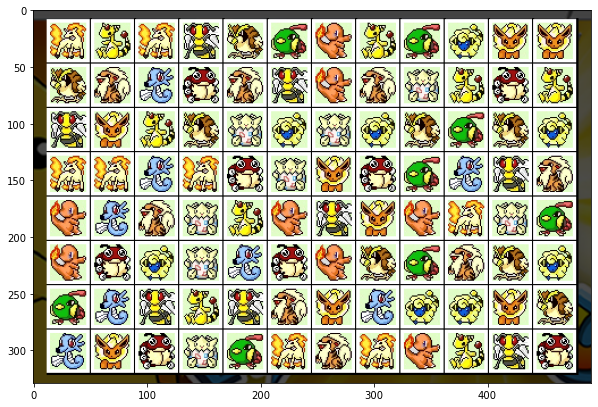

In [10]:
plt.imshow(img_1[:,:,::-1])

In [11]:
gray_img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)

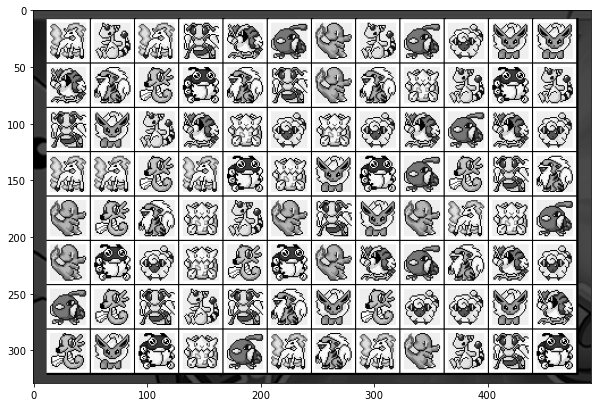

In [12]:
plt.imshow(gray_img_1, cmap = "gray")

Edge detection

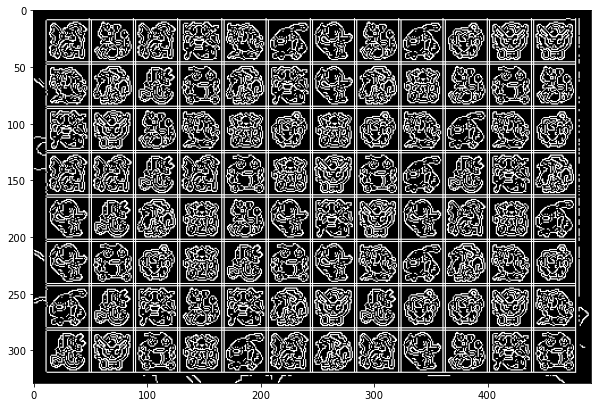

In [13]:
edges_img_1 = cv2.Canny(gray_img_1, 200, 240, 30)
plt.imshow(edges_img_1, cmap='gray')

In [14]:
copy = img_1.copy()

linesP = cv2.HoughLinesP(edges_img_1, 1, np.pi/180, 250, None, 50, 15)

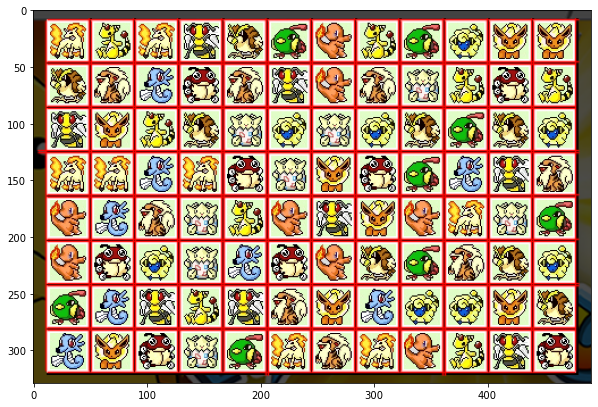

In [15]:
for i in range(0, len(linesP)):
    l = linesP[i][0]
    cv2.line(copy, (l[0], l[1]), (l[2], l[3]), (0,0,255), 1, cv2.LINE_AA)

    plt.imshow(copy[...,::-1])

[ 12   9 481   9]


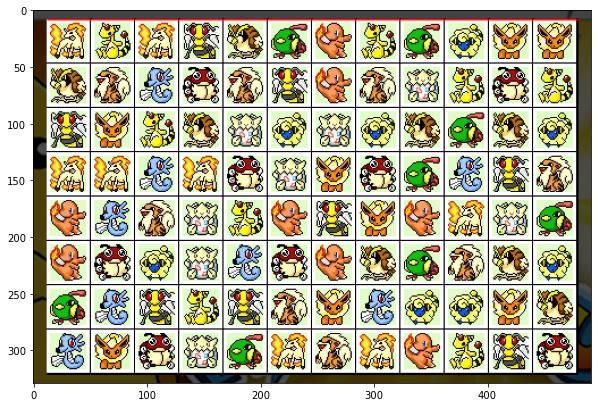

In [16]:
l = linesP[2][0]
print(l)
copy2 = img_1.copy()
cv2.line(copy2, (l[0], l[1]), (l[2], l[3]), (0,0,255), 1, cv2.LINE_AA)
plt.imshow(copy2[...,::-1])

In [17]:
linesP.shape

(40, 1, 4)

In [18]:
horizontal_lines = []
vertical_lines = []

In [19]:
for i in range(0, len(linesP)):
    l = linesP[i][0]
    if (l[0] == l[2]):
        vertical_lines.append(l)
    elif (l[1] == l[3]):
        horizontal_lines.append(l);

In [20]:
print(f"Number of horizontal lines: {len(horizontal_lines)}")
print(f"Number of vertical lines: {len(vertical_lines)}")

Number of horizontal lines: 16
Number of vertical lines: 24


We see that all lines are either horizontal or vertical.

Now we will sort horizontal lines list and vertical lines list to create some order.

In [71]:
width = int(len(vertical_lines)/2)
height = int(len(horizontal_lines)/2)
print(width, height)

12 8


In [21]:
def hori(l):
    return l[1]
horizontal_lines.sort(key = hori)

In [22]:
def verti(l):
    return l[0]
vertical_lines.sort(key = verti)

In [24]:
horizontal_lines[0]

array([ 12,   9, 481,   9], dtype=int32)

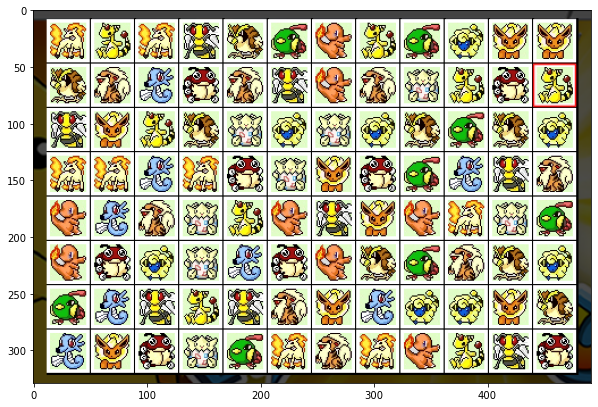

In [46]:
point_1 = (vertical_lines[22][0], horizontal_lines[2][1])
point_2 = (vertical_lines[23][0], horizontal_lines[3][1])
copy2 = img_1.copy()
cv2.rectangle(copy2, point_1, point_2, (0,0,255), 1, cv2.LINE_AA)
plt.imshow(copy2[...,::-1])


In [64]:
vertical_lines[0]

array([ 11, 318,  11,  10], dtype=int32)

In [112]:
pokemons = []
for index in range(height):
    pokemon = []
    for jndex in range(width):
        topleft = (vertical_lines[jndex*2][0], horizontal_lines[index * 2][1])
        bottomright = (vertical_lines[jndex*2 + 1][0], horizontal_lines[index * 2 + 1][1])
        pokemon.append((topleft, bottomright))
    pokemons.append(pokemon)

print(f"row: {len(pokemons)}, col: {len(pokemons[0])}")

row: 8, col: 12


In [110]:
len(img_1[0])

492

In [117]:
print(pokemons[0][11])

((441, 9), (478, 46))


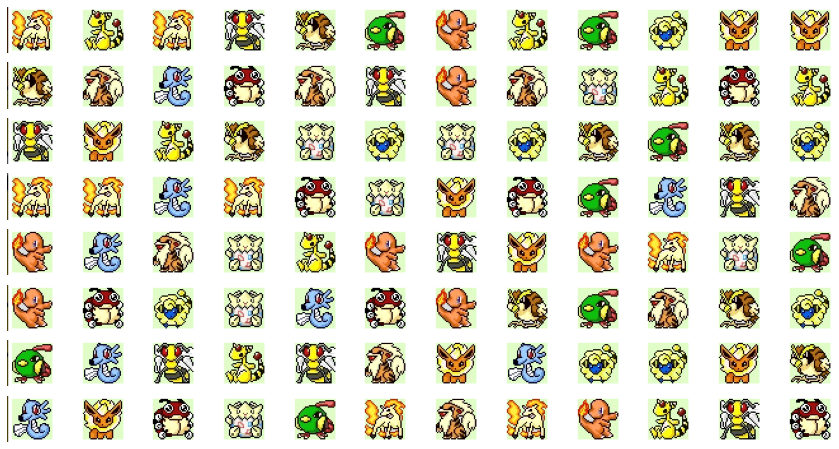

In [123]:
fig, ax = plt.subplots(height, width)
plt.rcParams['figure.figsize'] = [12,8]
for index in range(height):
    for jndex in range(width):
        topleft, bottomright = pokemons[index][jndex][0],  pokemons[index][jndex][1]
        temp_img = img_1[topleft[1]:bottomright[1], topleft[0]:bottomright[0]]
        ax[index][jndex].axis('off')
        ax[index][jndex].imshow(temp_img[:,:,::-1])

## Detecting the same pokemon

The original image

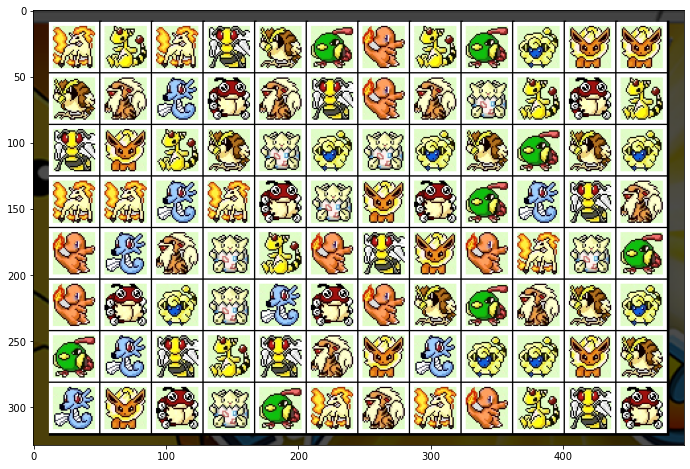

In [125]:
plt.imshow(img_1[:,:,::-1])

### Detecting and visuallize result

In [166]:
def detectingPokemon(img, template, meth="cv2.TM_CCORR"):
    method = eval(meth)
    if len(img.shape) == 3:
        print("3 channels image")
        b, r, g = cv2.split(img)
        temp_b, temp_r, temp_g = cv2.split(template)
        
        res_b = cv2.matchTemplate(b, temp_b, method)
        res_r = cv2.matchTemplate(r, temp_r, method)
        res_g = cv2.matchTemplate(g, temp_g, method)
        res = np.add(res_b, res_r, res_g)
    else: 
        print("The input image have only gray channel")
        return
    
    return res

In [185]:
def display(img, top_left_origin, bottom_right_origin, res):
    template = img[top_left_origin[1]:bottom_right_origin[1], top_left_origin[0]:bottom_right_origin[0]]
    h, w, c = template.shape
    res_height, res_width = res.shape
    
    max_val = np.amax(res)
    locs = []
    
    threshold = 0.97
    for index in range(res_height):
        for jndex in range(res_width):
            if res[index][jndex] >= threshold*max_val:
                locs.append((jndex, index))
    print(locs)

    img_copy = img.copy()
    
    #loop for every single one who have the same value as max point
    for loc in locs:
        top_left = loc
        bottom_right = ((loc[0] + w), (loc[1] + h))
        cv2.rectangle(img_copy, top_left, bottom_right, (0, 255, 0), 2)
        
    cv2.rectangle(img_copy, top_left_origin, bottom_right_origin, (0, 0, 255), 2)
    plt.axis('off')
    plt.imshow(img_copy[:,:,::-1])

### Demo simple pokemon

I'm taking the first pokemon of the board which location in [0, 0]

'Cause we have cropped all the pokemon, so I just have to take the `top_left` and `bottom_right` of the its from `pokemons` to became its own template for template matching algorithm above

In this case, I'm using TM_CCORR with 3 channels color. Good result confirmed!

In [184]:
#demo
topleft, bottomright = pokemons[0][0][0],  pokemons[0][0][1]
template = img_1[topleft[1]:bottomright[1], topleft[0]:bottomright[0]]

res_1 = detectingPokemon(img_1, template)

3 channels image


At function `detectingPokemon`, I've already create a list name `locs` contains all the position which have the value approximately equal to the max value

[(11, 9), (89, 9), (11, 126), (50, 126), (128, 126), (362, 165), (206, 282), (284, 282)]


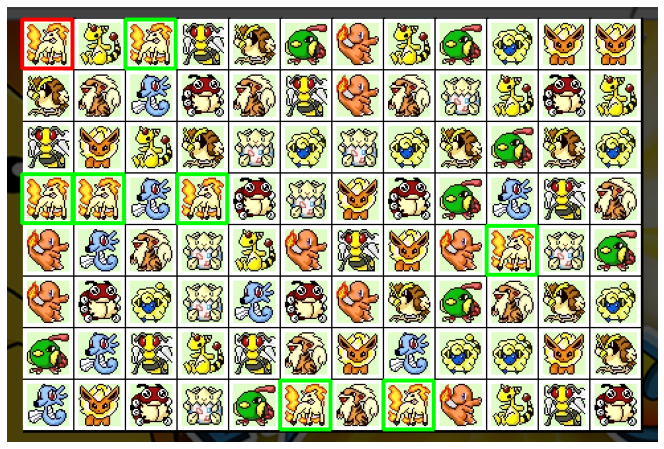

In [186]:
#display test result
#red box presents the current position, green boxs present all the same pokemon
display(img_1, topleft, bottomright, res_1)